In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Subset

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
print(device)

cuda


In [3]:
bs = 100 #paper 64, blog 256 -- ideal batch size ranges from 32 to 128

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) #mean 0.5, and std dev 0.5

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

print(len(train_dataset), len(test_dataset))
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle = True)
print(len(train_loader), len(test_loader))

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!
60000 10000
600 100


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3) #if we are overfitting
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [5]:
print(train_dataset.data.size(0),train_dataset.data.size(1),train_dataset.data.size(2))

60000 28 28


In [6]:
z_dim = 100
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

In [7]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [8]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [9]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [10]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [11]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [12]:
n_epoch = 1000
st_losses_g = [] #store losses for plotting
st_losses_d = [] #store losses for plotting
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))
    st_losses_g.append(torch.mean(torch.FloatTensor(G_losses))) #add this to other one
    st_losses_d.append(torch.mean(torch.FloatTensor(D_losses))) #add this to other one
    
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    if epoch == 1 or epoch %10 == 0:
        with torch.no_grad():
            test_z = Variable(torch.randn(bs, z_dim).to(device)) #generate noise
            generated = G(test_z)
            filename = './output_bs100/GAN_bs100_%04d_epoch.png' %epoch
            save_image(generated.view(100, 1, 28, 28), filename)

[1/1000]: loss_d: 0.915, loss_g: 2.880
[2/1000]: loss_d: 0.975, loss_g: 2.111
[3/1000]: loss_d: 0.892, loss_g: 1.781
[4/1000]: loss_d: 0.431, loss_g: 3.172
[5/1000]: loss_d: 0.466, loss_g: 3.066
[6/1000]: loss_d: 0.542, loss_g: 2.706
[7/1000]: loss_d: 0.468, loss_g: 3.162
[8/1000]: loss_d: 0.577, loss_g: 2.624
[9/1000]: loss_d: 0.579, loss_g: 2.628
[10/1000]: loss_d: 0.609, loss_g: 2.551
[11/1000]: loss_d: 0.630, loss_g: 2.452
[12/1000]: loss_d: 0.663, loss_g: 2.353
[13/1000]: loss_d: 0.739, loss_g: 2.117
[14/1000]: loss_d: 0.737, loss_g: 2.183
[15/1000]: loss_d: 0.783, loss_g: 2.002
[16/1000]: loss_d: 0.804, loss_g: 1.909
[17/1000]: loss_d: 0.772, loss_g: 2.031
[18/1000]: loss_d: 0.831, loss_g: 1.813
[19/1000]: loss_d: 0.808, loss_g: 1.918
[20/1000]: loss_d: 0.886, loss_g: 1.718
[21/1000]: loss_d: 0.908, loss_g: 1.633
[22/1000]: loss_d: 0.935, loss_g: 1.537
[23/1000]: loss_d: 0.939, loss_g: 1.572
[24/1000]: loss_d: 0.917, loss_g: 1.586
[25/1000]: loss_d: 0.948, loss_g: 1.512
[26/1000]

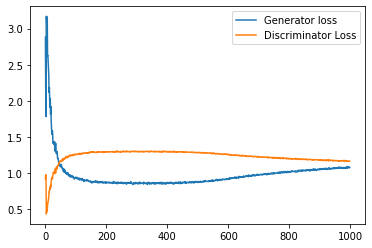

In [13]:
# plot and save the generator and discriminator loss
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
plt.plot(st_losses_g, label='Generator loss')
plt.plot(st_losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('./output_bs100/GAN_loss_bs100_1000epoch.png')

In [14]:
!zip -r /content/output.zip /content/output_bs100

  adding: content/output_bs100/ (stored 0%)
  adding: content/output_bs100/GAN_bs100_0010_epoch.png (deflated 5%)
  adding: content/output_bs100/GAN_bs100_0120_epoch.png (deflated 3%)
  adding: content/output_bs100/GAN_bs100_0560_epoch.png (deflated 4%)
  adding: content/output_bs100/GAN_bs100_0410_epoch.png (deflated 3%)
  adding: content/output_bs100/GAN_bs100_0450_epoch.png (deflated 4%)
  adding: content/output_bs100/GAN_bs100_0790_epoch.png (deflated 4%)
  adding: content/output_bs100/GAN_bs100_0810_epoch.png (deflated 4%)
  adding: content/output_bs100/GAN_bs100_0140_epoch.png (deflated 3%)
  adding: content/output_bs100/GAN_bs100_0950_epoch.png (deflated 4%)
  adding: content/output_bs100/GAN_loss_bs100_1000epoch.png (deflated 6%)
  adding: content/output_bs100/GAN_bs100_0820_epoch.png (deflated 3%)
  adding: content/output_bs100/GAN_bs100_0210_epoch.png (deflated 4%)
  adding: content/output_bs100/GAN_bs100_0110_epoch.png (deflated 3%)
  adding: content/output_bs100/GAN_bs100_0

In [15]:
from google.colab import files
files.download("/content/output.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>